<a href="https://colab.research.google.com/github/chuanlintneoh/OvarianCystClassification/blob/main/TensorFlow_Ovarian_Cyst_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preview: E2E Model

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

default_dir = '/content/drive/MyDrive/UM Artificial Intelligence/Y3S1/Ovarian Cyst Prediction/Implementation'
print(os.listdir(default_dir))

['e2e.zip', 'PyTorch DenseNet121', 'TensorFlow DenseNet121']


In [ ]:
import zipfile

e2e_dir = os.path.join(default_dir, 'e2e.zip')
print(e2e_dir)

# Create temp directory that only exist during current session
e2e_extract_temp_dir = 'content/e2e_extracted_temp'
os.makedirs(e2e_extract_temp_dir, exist_ok=True)
# Unzip file
with zipfile.ZipFile(e2e_dir, 'r') as zip_ref:
    zip_ref.extractall(e2e_extract_temp_dir)

e2e_extract_temp_dir = os.path.join(e2e_extract_temp_dir, 'e2e')
print(os.listdir(e2e_extract_temp_dir))

/content/drive/MyDrive/UM Artificial Intelligence/Y3S1/Ovarian Cyst Prediction/Implementation/e2e.zip
['Malignant', 'Benign']


In [ ]:
import cv2
import numpy as np

images = []
labels = []
e2e_benign_dir = os.path.join(e2e_extract_temp_dir, 'Benign')
e2e_malignant_dir = os.path.join(e2e_extract_temp_dir, 'Malignant')

for label, folder in enumerate([e2e_benign_dir, e2e_malignant_dir]):
    # 0 ([1,0]) for Benign, ([0,1]) for Malignant
    for image in os.listdir(folder):
        if label == 0:
            labels.append([1,0]) # Benign
        else:
            labels.append([0,1]) # Malignant

        # each image 224px x 224px, each pixel 3 color values (R,G,B), normalized to range 0-1 (originally 0-255)
        img = cv2.imread(os.path.join(folder, image))
        img = cv2.resize(img, (224, 224))
        img = img / 255.0 # Normalize
        images.append(img)
        # Example: images[0][1][2] -> first image, second row, third column will have shape (3), each corresponding to color value of RGB

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Count the number of benign (0) and malignant (1) images
benign_count = np.sum(np.all(labels == [1, 0], axis=1))
malignant_count = np.sum(np.all(labels == [0, 1], axis=1))

print(f"Number of Benign images: {benign_count}")
print(f"Number of Malignant images: {malignant_count}")
print(images.shape)
print(labels.shape)

Number of Benign images: 148
Number of Malignant images: 94
(242, 224, 224, 3)
(242, 2)


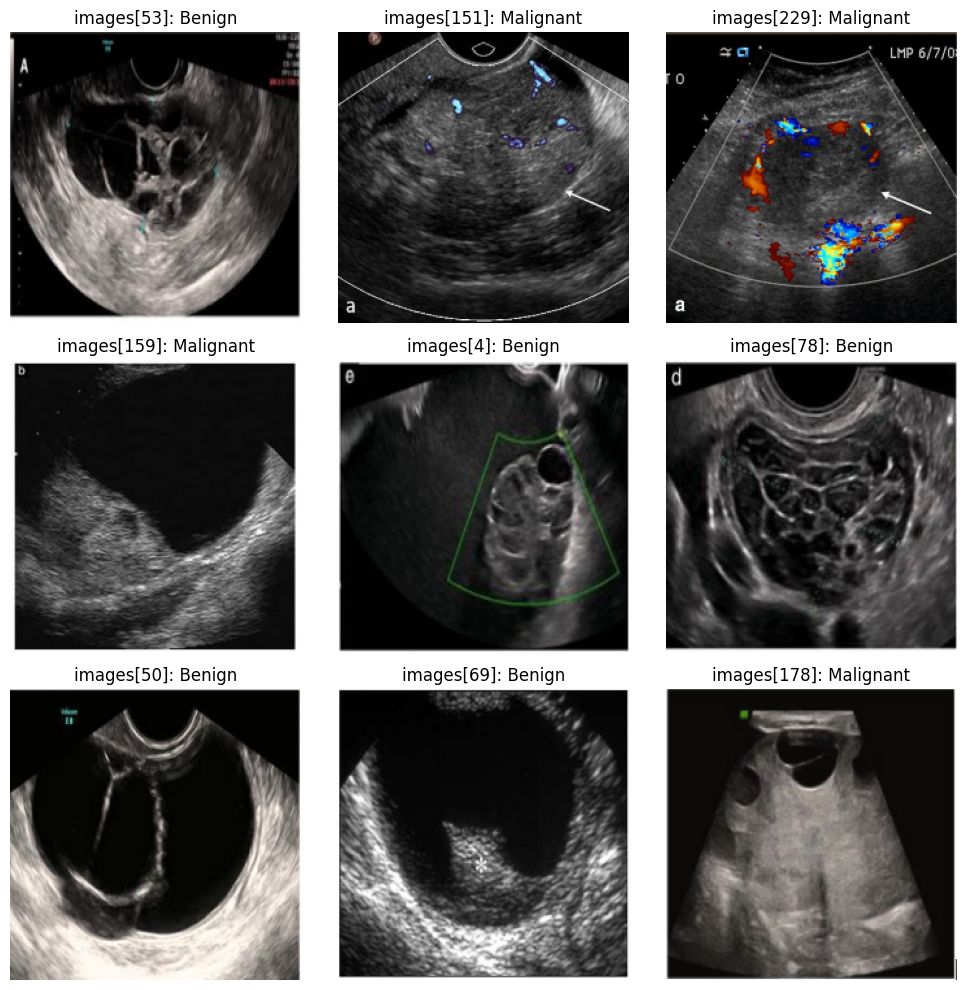

In [ ]:
# Pure visualization purpose, no processing involved

import matplotlib.pyplot as plt
import random

# Display some original images (benign and malignant)
plt.figure(figsize=(10, 10))
for i in range(9):
    randNum = random.randint(0, len(images)-1)
    plt.subplot(3, 3, i+1)
    plt.imshow(images[randNum])
    label = 'Benign' if np.array_equal(labels[randNum],[1,0]) else 'Malignant'
    plt.title(f"images[{randNum}]: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Verify shapes of training and validation sets
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

# X_train: Images for training
# X_val: Images for validation
# y_train: Corresponding labels for training
# y_val: Corresponding labels for validation

X_train shape: (193, 224, 224, 3)
X_val shape: (49, 224, 224, 3)
y_train shape: (193, 2)
y_val shape: (49, 2)


In [ ]:
# Class imbalance adjustment

from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# Flatten the one-hot encoded labels to get class indices
y_train_labels = np.argmax(y_train, axis=1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)

# Convert to a dictionary format for TensorFlow
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.8109243697478992, 1: 1.304054054054054}


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the augmentation parameters
datagen = ImageDataGenerator(
    # rotation_range=10,       # Rotate images up to 10 degrees
    width_shift_range=0.1,   # Shift images horizontally by 10%
    height_shift_range=0.1,  # Shift images vertically by 10%
    zoom_range=0.2,          # Zoom in/out by 20%
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill mode for points outside boundaries
)

# Fit the generator on the data (optional for certain augmentations)
datagen.fit(images)

# Create augmented data batches for training
train_generator = datagen.flow(X_train, y_train, batch_size=64)

(64, 224, 224, 3)
(64, 2)


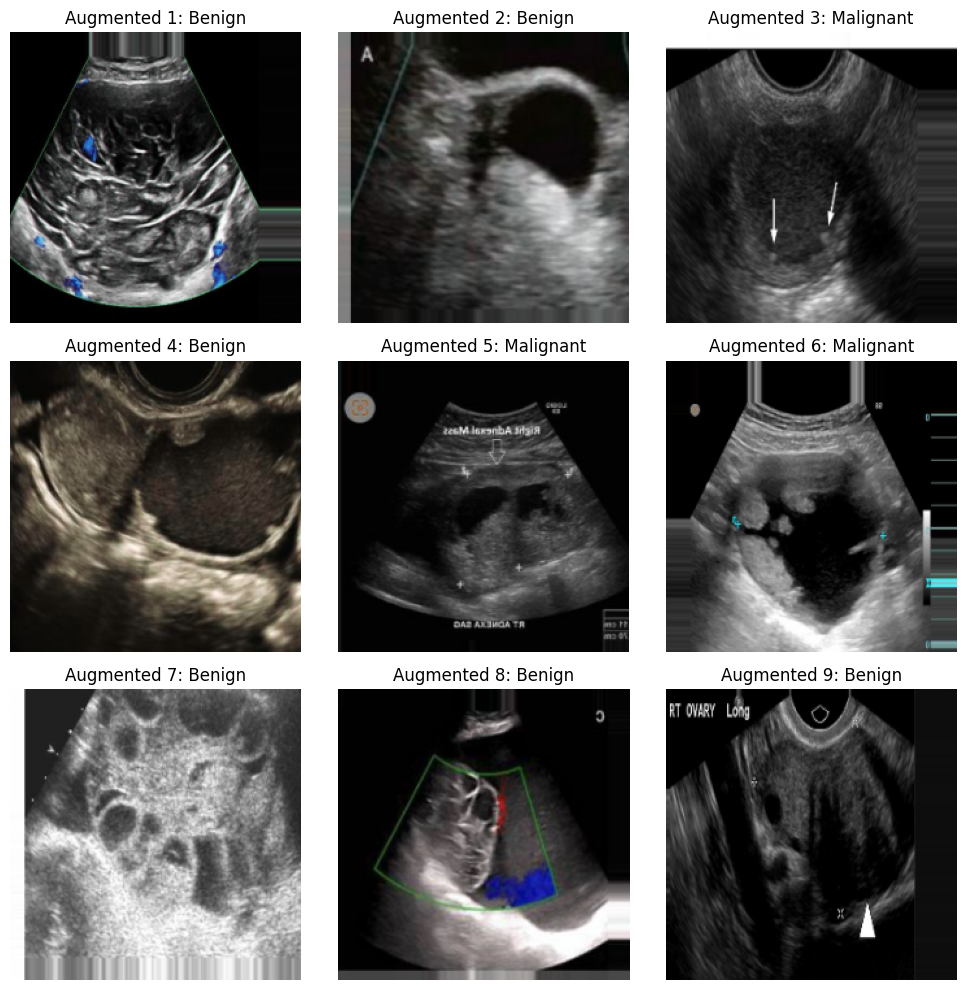

In [ ]:
# Pure visualization purpose, no processing involved

# import matplotlib.pyplot as plt

# Take a batch of images and display some augmented versions
augmented_images, augmented_labels = next(train_generator)
print(augmented_images.shape)
print(augmented_labels.shape)

# Plotting a few augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i])
    label = 'Benign' if np.array_equal(augmented_labels[i],[1,0]) else 'Malignant'
    plt.title(f"Augmented {i+1}: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Create model architecture

from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
# DenseNet 121, 169, 201, 264 => increasing DenseNet model complexity

# Load DenseNet121 model pre-trained on ImageNet, excluding the top layer for transfer learning
feature_extractor = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model so that its weights aren't updated during training
feature_extractor.trainable = False

# Create the model
e2e_model = models.Sequential()

# Add the DenseNet base model as a feature extractor
e2e_model.add(feature_extractor)

# Add a global average pooling layer to reduce the dimensions
e2e_model.add(layers.GlobalAveragePooling2D())

# Add a fully connected layer (Dense) and ReLU activation
e2e_model.add(layers.Dense(256, activation='relu'))

# Dropout layer to avoid overfitting
e2e_model.add(layers.Dropout(0.3))

# Output layer for binary classification (2 classes)
e2e_model.add(layers.Dense(2, activation='softmax'))

# Compile the model
e2e_model.compile(
    optimizer=Adam(learning_rate=0.001), # default is 0.001
    loss='categorical_crossentropy',
    metrics=['accuracy','AUC']
)

# Print model summary
e2e_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,300,418 (27.85 MB)

 Trainable params: 262,914 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Function to determine the best epoch model based on AUC
# def determine_best_epoch(history):
#     best_epoch = np.argmax(history["val_auc"]) + 1  # Find epoch with highest AUC
#     best_score = history["val_auc"][best_epoch - 1]  # Get the AUC score of best epoch
#     return best_epoch, best_score

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
# from sklearn.metrics import roc_auc_score
# from tensorflow.keras.callbacks import ModelCheckpoint

# initial_best_epoch = None
# initial_best_score = -np.inf
# finetuned_best_epoch = None
# finetuned_best_score = -np.inf

# class BestEpochSaver(Callback):
#     # Custom history
#     def __init__(self, filepath, isInitialTrain, validation_data):
#         super(BestEpochSaver, self).__init__()
#         self.filepath = filepath
#         self.isInitialTrain = isInitialTrain
#         self.validation_data = validation_data
#         self.history = {
#             "accuracy": [],
#             "val_accuracy": [],
#             "loss": [],
#             "val_loss": [],
#             "val_auc": []
#         }  # Store history
#         self.epoch_files = []  # Store file paths for cleanup

#     def on_epoch_end(self, epoch, logs=None):
        # if logs is None:
        #     return

        # # Compute ROC AUC for validation set
        # X_val, y_val = self.validation_data  # Unpack validation data
        # val_probs = self.model.predict(X_val)  # Get softmax probabilities
        # val_true = np.argmax(y_val, axis=1)  # Convert one-hot to binary labels
        # val_auc = roc_auc_score(val_true, val_probs[:, 1])  # AUC using malignant class

        # # Store logs in the callback's history
        # for key in self.history.keys():
        #     if key in logs:
        #         self.history[key].append(logs[key])
        # self.history["val_auc"].append(val_auc)  # Store AUC score

        # Save model weights at each epoch
    #     epoch_filepath = f"{self.filepath}_epoch_{epoch+1}.weights.h5"
    #     self.model.save_weights(epoch_filepath)
    #     self.epoch_files.append(epoch_filepath)  # Track saved files

    # def on_train_end(self, logs=None):
    #   # Compute best epoch AFTER training
    #   best_epoch, best_score = determine_best_epoch(self.history)

    #   if self.isInitialTrain:
    #     global initial_best_epoch, initial_best_score  # Use global variables
    #     initial_best_epoch, initial_best_score = best_epoch, best_score
    #   else:
    #     global finetuned_best_epoch, finetuned_best_score  # Use global variables
    #     finetuned_best_epoch, finetuned_best_score = best_epoch, best_score

    #   # Load the best epoch's model weights
    #   best_model_path = f"{self.filepath}_epoch_{best_epoch}.weights.h5"
    #   self.model.load_weights(best_model_path)
    #   print(f"\n✅ Training complete. Best epoch: {best_epoch} with AUC {best_score:.4f}")
    #   print(f"🔄 Loaded best model from {best_model_path}")

    #   # Delete other epoch weight files
    #   for epoch_file in self.epoch_files:
    #       if epoch_file != best_model_path and os.path.exists(epoch_file):
    #           os.remove(epoch_file)
    #           print(f"🗑️ Deleted {epoch_file} to save space")

# Add callbacks
callbacks = [
    EarlyStopping(monitor='val_AUC', patience=5, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    # ReduceLROnPlateau(monitor='val_AUC', factor=0.2, patience=5, mode='max', min_lr=1e-6, verbose=1),
    # BestEpochSaver(filepath="initialModel", isInitialTrain=True, validation_data=(X_val, y_val))
    # ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Area Under Curve (AUC): Probability of model, if given a randomly chosen positive and negative example, will rank the positive higher than the negative.
# Training AUC: Computed on the training data during each epoch, shows how well the model is distinguishing between classes on the training set.
# Validation AUC
# 1. Manually computed in BestEpochSaver: Computed on entire validation set at once (After each epoch, on the entire dataset)
# 2. Computed by Keras: Computed batch-wise and then averaged (During validation per batch & epoch)
# 1 and 2 should be close, if they're significantly different, check batch sizes, class imbalance, or how probabilities are extracted.
# A high AUC here might indicate good learning—but if it's much higher than validation AUC, overfitting might be happening.

In [ ]:
history = e2e_model.fit(
    train_generator,
    epochs=50, # Allow more epochs with callbacks
    # batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=callbacks
)

initial_best_epoch = np.argmax(history.history['val_AUC']) + 1
print(f"\n✅ Training complete. Best epoch: {initial_best_epoch}.")

epoch_filepath = f"initialModel_epoch_{initial_best_epoch}.weights.h5"
e2e_model.save_weights(epoch_filepath)
print(f"🔄 Saved best model from epoch {initial_best_epoch} as {epoch_filepath}.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 9s/step - AUC: 0.5741 - accuracy: 0.5853 - loss: 0.8151 - val_AUC: 0.6177 - val_accuracy: 0.6122 - val_loss: 1.2974 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - AUC: 0.7558 - accuracy: 0.6731 - loss: 1.0351 - val_AUC: 0.5760 - val_accuracy: 0.5714 - val_loss: 0.8816 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step - AUC: 0.7005 - accuracy: 0.6492 - loss: 0.6703 - val_AUC: 0.6614 - val_accuracy: 0.6122 - val_loss: 0.7635 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 777ms/step - AUC: 0.8203 - accuracy: 0.7260 - loss: 0.6431 - val_AUC: 0.6797 - val_accuracy: 0.6327 - val_loss: 0.7377 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 496ms/step - AUC: 0.7871 - accuracy: 0.7131 - loss: 0.5979 - val_AUC: 0.5344 - val_accuracy: 0.5306 - val_loss: 1.1841 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 571ms/step - AUC: 0.6456 - accuracy: 0.5454 - loss: 0

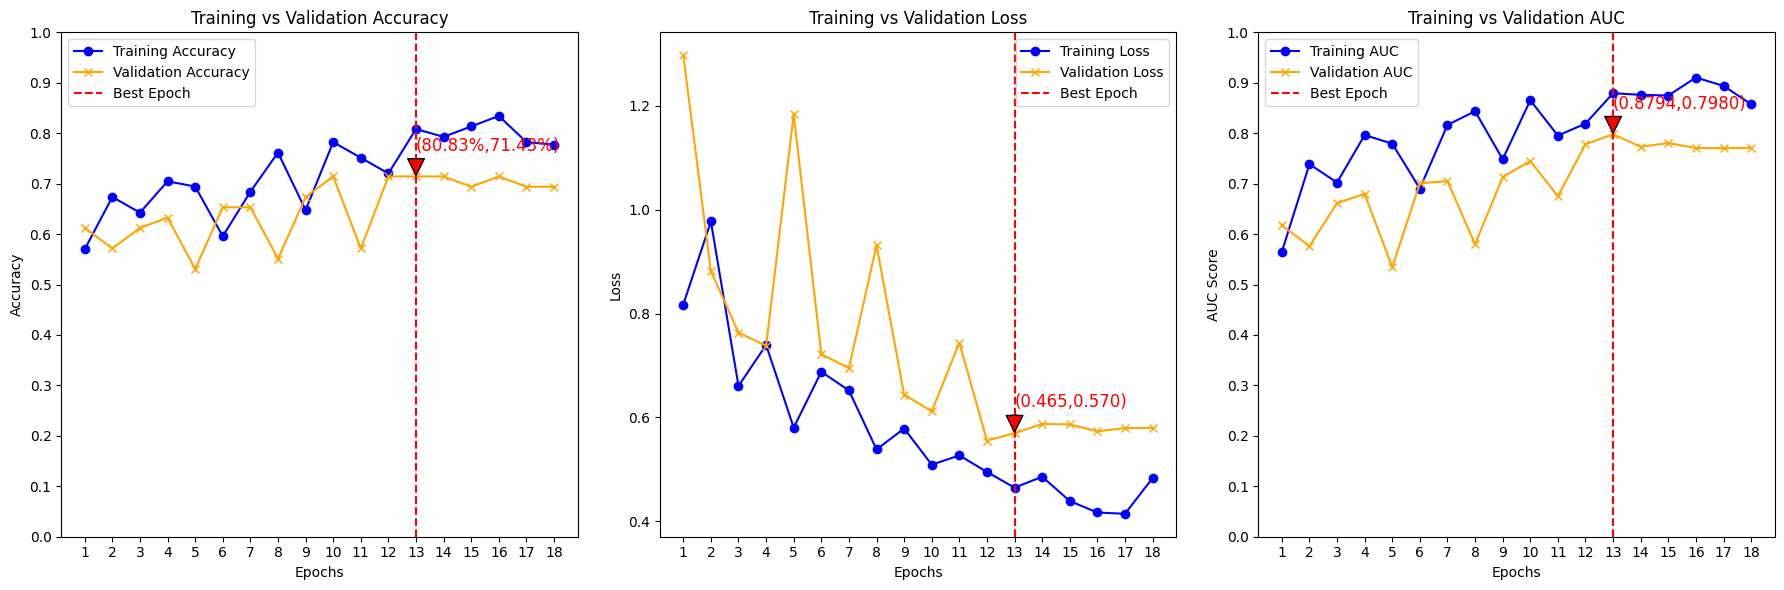

In [ ]:
# Pure visualization purpose, no processing involved

# import matplotlib.pyplot as plt

def plot_learning_curves(history,isInitialTrain):
  # Extracting the training and validation accuracy
  train_accuracy = history['accuracy']
  val_accuracy = history['val_accuracy']

  # Extracting the training and validation loss
  train_loss = history['loss']
  val_loss = history['val_loss']

  # Extracting the training and validation AUC (computed by Keras)
  train_AUC = history["AUC"]
  val_AUC = history["val_AUC"]

  # Epochs range
  epochs = range(1, len(train_accuracy) + 1)

  if "finetuned_best_epoch" in globals():
    best_epoch = initial_best_epoch if isInitialTrain else finetuned_best_epoch
  else:
    best_epoch = initial_best_epoch

  # Create two subplots
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

  # Plot Training and Validation Accuracy
  ax1.plot(epochs, train_accuracy, label='Training Accuracy', color='blue', marker='o')
  ax1.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange', marker='x')
  ax1.set_title('Training vs Validation Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.set_xticks(epochs)
  ax1.set_ylim(0, 1)
  ax1.set_yticks([i / 10 for i in range(11)])
  ax1.annotate(f'({train_accuracy[best_epoch-1]*100:.2f}%,{val_accuracy[best_epoch-1]*100:.2f}%)',
               xy=(best_epoch, val_accuracy[best_epoch-1]),
               xytext=(best_epoch, val_accuracy[best_epoch-1] + 0.05),
               arrowprops=dict(facecolor='red', shrink=0.05),
               fontsize=12, color='red')
  ax1.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
  ax1.legend()

  # Plot Training and Validation Loss
  ax2.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
  ax2.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='x')
  ax2.set_title('Training vs Validation Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.set_xticks(epochs)
  ax2.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
  ax2.annotate(f'({train_loss[best_epoch-1]:.3f},{val_loss[best_epoch-1]:.3f})',
               xy=(best_epoch, val_loss[best_epoch-1]),
               xytext=(best_epoch, val_loss[best_epoch-1] + 0.05),
               arrowprops=dict(facecolor='red', shrink=0.05),
               fontsize=12, color='red')
  ax2.legend()

  # Plot AUC
  ax3.plot(epochs, train_AUC, label="Training AUC", color="blue", marker="o")
  ax3.plot(epochs, val_AUC, label="Validation AUC", color="orange", marker="x")
  ax3.set_title("Training vs Validation AUC")
  ax3.set_xlabel("Epochs")
  ax3.set_ylabel("AUC Score")
  ax3.set_xticks(epochs)
  ax3.set_ylim(0, 1)
  ax3.set_yticks([i / 10 for i in range(11)])
  ax3.axvline(x=best_epoch, color="red", linestyle="--", label="Best Epoch")
  ax3.annotate(f'({train_AUC[best_epoch-1]:.4f},{val_AUC[best_epoch-1]:.4f})',
               xy=(best_epoch, val_AUC[best_epoch-1]),
               xytext=(best_epoch, val_AUC[best_epoch-1] + 0.05),
               arrowprops=dict(facecolor='red', shrink=0.05),
               fontsize=12, color='red')
  ax3.legend()

  # Display the plots
  plt.tight_layout()
  plt.show()

plot_learning_curves(history=history.history, isInitialTrain=True)

# Training accuracy and training loss is not perfectly inversely proportional because
# loss measures the confidence of model's predictions,
# accuracy only measures the number of correct predictions.
# If the model predicts probabilities [0.6, 0.4] for two classes,
# accuracy may consider it correct if the label is [1, 0],
# but the loss will still be relatively high because the confidence (0.6) is not very strong.

# Training Accuracy and Loss: Check if the model is learning properly.
# Validation Accuracy and Loss: Check if the model is generalizing well.

# Both training and validation loss decreasing with increasing accuracy indicates good learning.
# Diverging trends (e.g., training loss decreasing while validation loss increases) indicate potential overfitting.

In [ ]:
# Finetuning
# Expect at least 0.75 validation AUC before finetuning
finetune_threshold = 0.75

finetuned = False
if history.history['val_AUC'][initial_best_epoch-1] > finetune_threshold:
  finetuned = True

  # Unfreeze the base model for fine-tuning
  for layer in feature_extractor.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

  # Compile model
  e2e_model.compile(
      optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
      loss='categorical_crossentropy',
      metrics=['accuracy','AUC']
  )

  # Train model
  fine_tune_history = e2e_model.fit(
      train_generator,
      validation_data=(X_val, y_val),
      epochs=20,
      callbacks=[
          # BestEpochSaver(filepath='finetunedModel', isInitialTrain=False, validation_data=(X_val, y_val)),
          EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)
          ],
      # initial_epoch=initial_best_epoch # irrelevant since best epoch weights already saved in `e2e_model`
  )

  finetuned_best_epoch = np.argmax(fine_tune_history.history['val_AUC']) + 1
  print(f"\n✅ Finetuning complete. Best epoch: {finetuned_best_epoch}.")

  finetuned_epoch_filepath = f"finetunedModel_epoch_{finetuned_best_epoch}.weights.h5"
  e2e_model.save_weights(finetuned_epoch_filepath)
  print(f"🔄 Saved best model from epoch {finetuned_best_epoch} as {finetuned_epoch_filepath}.")

else:
  print("Finetune skipped due to poor model performance. Please retrain model from scratch.")

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 14s/step - AUC: 0.7142 - accuracy: 0.6578 - loss: 0.4966 - val_AUC: 0.7988 - val_accuracy: 0.7143 - val_loss: 0.5711
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - AUC: 0.8945 - accuracy: 0.7956 - loss: 0.4109 - val_AUC: 0.7963 - val_accuracy: 0.6939 - val_loss: 0.5714
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 761ms/step - AUC: 0.8934 - accuracy: 0.8339 - loss: 0.4120 - val_AUC: 0.7951 - val_accuracy: 0.6939 - val_loss: 0.5721
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 741ms/step - AUC: 0.9315 - accuracy: 0.8481 - loss: 0.3635 - val_AUC: 0.7918 - val_accuracy: 0.6939 - val_loss: 0.5751

✅ Finetuning complete. Best epoch: 1.
🔄 Saved best model from epoch 1 as finetunedModel_epoch_1.weights.h5.


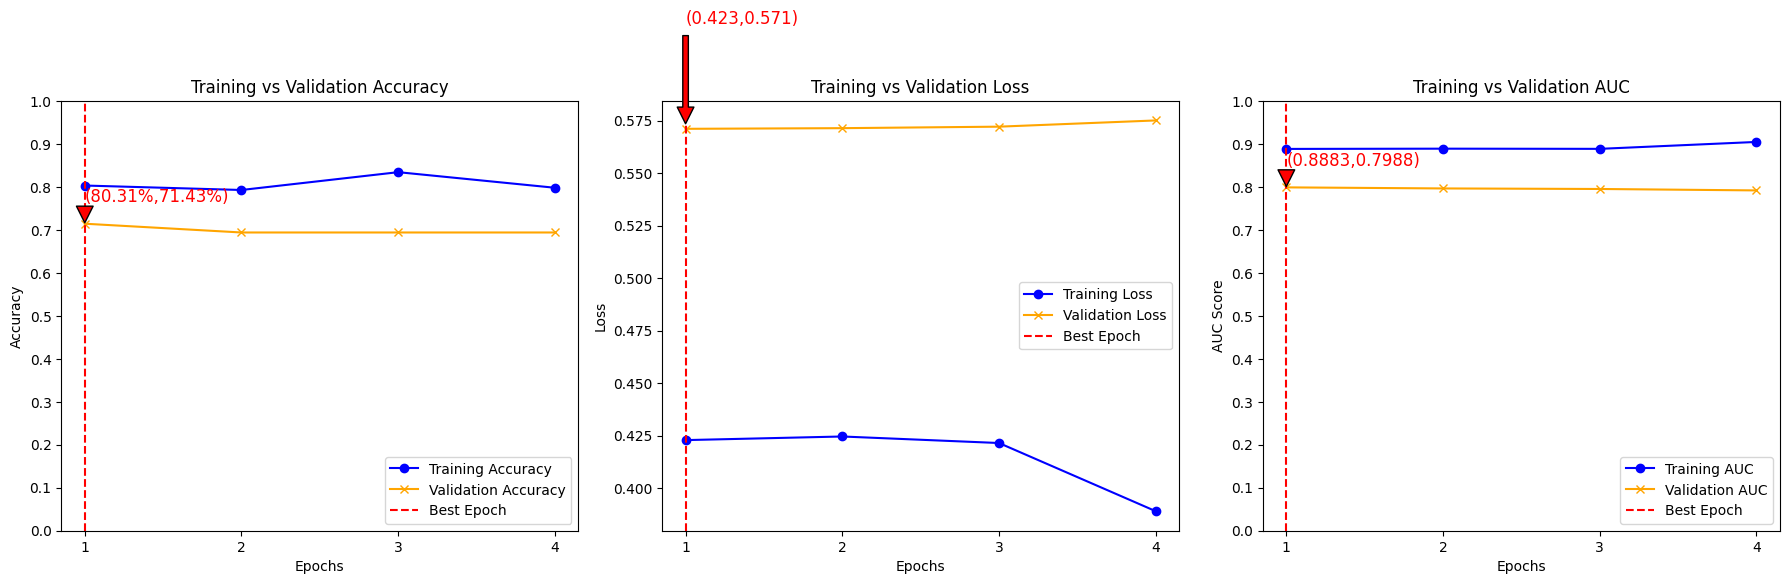

In [ ]:
if finetuned:
  plot_learning_curves(history=fine_tune_history.history, isInitialTrain=False)

In [ ]:
# Compare model performance before and after finetuning
# Save better model
import datetime

if finetuned:
    # Extract best AUC scores from validation set
    initial_v_AUC = history.history["val_AUC"][initial_best_epoch - 1]
    finetuned_v_AUC = fine_tune_history.history["val_AUC"][finetuned_best_epoch - 1]

    print(f"Initial model AUC: {initial_v_AUC:.4f}")
    print(f"Finetuned model AUC: {finetuned_v_AUC:.4f}")

    # Decide which model to keep based on AUC
    if initial_v_AUC > finetuned_v_AUC:
        print("Finetune does not improve validation AUC, restoring initial model.")
        e2e_model.load_weights(f"initialModel_epoch_{initial_best_epoch}.weights.h5")
    else:
        print("Finetuned model has better AUC, keeping finetuned model.")

# Save the final model
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
e2e_model.save(f"final_model_{timestamp}.h5")

Initial model AUC: 0.7980
Finetuned model AUC: 0.7988
Finetuned model has better AUC, keeping finetuned model.
